In [1]:
from utilities import *

### Retrieving FRED data

In [7]:
fred = FredAPI(api_key='653a02fbb384cf3e9b29d458109c8b11')
cpi_release_dates = fred.getReleaseDates(release_id=10)
cpi_ts = fred.getSerieData(serie_id='CPIAUCNS', start_date='1960-01-01', end_date='9999-12-31', flag_real=True)

# convert & adjust date column that should be end of month
cpi_ts['date_adjusted'] = pd.to_datetime(cpi_ts.date, format="%Y-%m-%d") + pd.offsets.MonthEnd(0)
cpi_ts['realtime_start'] = pd.to_datetime(cpi_ts.realtime_start, format="%Y-%m-%d")

# get factors & industries returns
ff = FFData()
# industries
perf_sectors_raw = ff.getIndustryDailyData(data_source='10_Industry_Portfolios', weighting_scheme='value')
# factors
factors_raw = ff.getFactorDailyData()

### Training the Model

In [11]:
train_data = prepare_data(cpi_ts, perf_sectors_raw, cpi_release_dates, start_date='1949-02-28', end_date='1988-12-31', actual=False)
test_data = prepare_data(cpi_ts, perf_sectors_raw, cpi_release_dates, start_date='1988-12-31', end_date='2023-02-28', actual=True)

In [13]:
test_data.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Regime,Regime_code
Date,,,,,,,,,,,,
1991-01-16,1.11,0.68,0.70,-0.23,3.24,0.27,1.75,2.12,0.01,0.92,Higher & Rising,3.0
1991-01-17,4.44,3.59,4.38,0.47,3.86,4.56,4.56,2.71,2.00,3.23,Higher & Rising,3.0
1991-01-18,1.14,0.80,0.95,0.45,1.47,1.37,1.35,0.58,0.56,0.96,Higher & Rising,3.0
1991-01-21,-0.39,-0.62,-0.28,-1.26,1.59,0.02,-0.48,0.40,-0.13,0.19,Higher & Rising,3.0
1991-01-22,-0.07,-0.68,-0.85,0.45,-0.71,-3.00,-1.06,-0.43,-0.22,-0.13,Higher & Rising,3.0


In [14]:
assets = test_data.drop(columns=["Regime", "Regime_code"]) / 100
regimes = test_data[["Regime_code"]]
n_assets = len(assets.T)


In [15]:
# ranking weighting scheme
model_allocation = train_data.groupby('Regime_code').mean(numeric_only=True).rank(axis=1, ascending=True) / np.arange(1, n_assets+1).sum() 
# equal weight for benchmark
bench_allocation = model_allocation*0 + 1/len(model_allocation.columns)

### Backtesting

In [17]:
# portfolio backtest
bt = Backtest(data_returns=assets, data_trigger=regimes, data_allocation=model_allocation, start_date="1991-12-31", end_date="2023-02-28")
bt.run()
# benchmark backtest
bt_ref = Backtest(data_returns=assets, data_trigger=regimes, data_allocation=bench_allocation, start_date="1991-12-31", end_date="2023-02-28")
bt_ref.run()
# display annualized statistics
bt.compute_stats(bt_ref)

100%|██████████| 7848/7848 [00:06<00:00, 1182.73it/s]


,Return,Volatility,Turnover,Sharpe Ratio,Beta,Tracking Error,Information Ratio
Portfolio,0.123555,0.177830,1.609428,0.694793,1.000974,0.026725,0.410912
Benchmark,0.112573,0.175639,0.120113,0.640934,NaN,NaN,NaN


### Falsification

In [18]:
# falsification 1
regimes_false = (test_data[["Regime_code"]]-2).replace(-1,2).replace(-2,3)
bt_false = Backtest(data_returns=assets, data_trigger=regimes_false, data_allocation=model_allocation, start_date="1991-12-31", end_date="2023-01-31")
bt_false.run()
bt_false.compute_stats(bt_ref)

# falsification 2
regimes_false2 = (test_data[["Regime_code"]]-1).replace(-1,3)
bt_false2 = Backtest(data_returns=assets, data_trigger=regimes_false2, data_allocation=model_allocation, start_date="1991-12-31", end_date="2023-01-31")
bt_false2.run()
bt_false2.compute_stats(bt_ref)

# falsification 3
regimes_false3 = np.abs(test_data[["Regime_code"]]-3)
bt_false3 = Backtest(data_returns=assets, data_trigger=regimes_false3, data_allocation=model_allocation, start_date="1991-12-31", end_date="2023-01-31")
bt_false3.run()
bt_false3.compute_stats(bt_ref)

100%|██████████| 7829/7829 [00:06<00:00, 1221.90it/s]


,Return,Volatility,Turnover,Sharpe Ratio,Beta,Tracking Error,Information Ratio
Portfolio,0.096150,0.176423,1.583823,0.544999,0.991555,0.028662,-0.572988
Benchmark,0.112573,0.175639,0.120113,0.640934,NaN,NaN,NaN


### Strategy Eval

In [20]:
# against reference benchmark
X = bt_ref.portfolio_perf.Perf.dropna()
y = bt.portfolio_perf.Perf.dropna()
model = sm.GLS(y,sm.add_constant(X))
res = model.fit()
print(res.params[0]*260) # annualized alpha
res.summary()

0.010094419963846057


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   Perf   R-squared:                       0.977
Model:                            GLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 3.396e+05
Date:                Sun, 11 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:23:28   Log-Likelihood:                 39111.
No. Observations:                7848   AIC:                        -7.822e+04
Df Residuals:                    7846   BIC:                        -7.821e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.882e-05   1.87e-05      2.073      0.038    2.11e-06    7.55e-05
Perf           1.0010      0.002    582.710      0.000       0.998       1.004
==============================================================================
Omnibus:                      897.222   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8946.126
Skew:                          -0.008   Prob(JB):                         0.00
Kurtosis:                       8.230   Cond. No.                         91.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# against FF-5 factors
y = bt.portfolio_perf.Perf.dropna()
X = factors_raw.drop(columns=['RF']) / 100
X = X.loc[y.index]
y = y.loc[X.index]
model = sm.GLS(y,sm.add_constant(X))
res = model.fit()
print(res.params.const*260) # annualized alpha
res.summary()

0.028927357988650367


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   Perf   R-squared:                       0.941
Model:                            GLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 2.523e+04
Date:                Sun, 11 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:24:12   Log-Likelihood:                 35376.
No. Observations:                7848   AIC:                        -7.074e+04
Df Residuals:                    7842   BIC:                        -7.070e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   3.02e-05      3.685      0.000    5.21e-05       0.000
Mkt-RF         0.9589      0.003    333.450      0.000       0.953       0.965
SMB            0.0126      0.005      2.385      0.017       0.002       0.023
HML            0.0452      0.005      8.904      0.000       0.035       0.055
RMW            0.1446      0.007     21.027      0.000       0.131       0.158
CMA            0.2661      0.009     30.116      0.000       0.249       0.283
==============================================================================
Omnibus:                     1182.088   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19442.491
Skew:                          -0.073   Prob(JB):                         0.00
Kurtosis:                      10.709   Cond. No.                         313.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='Date'>

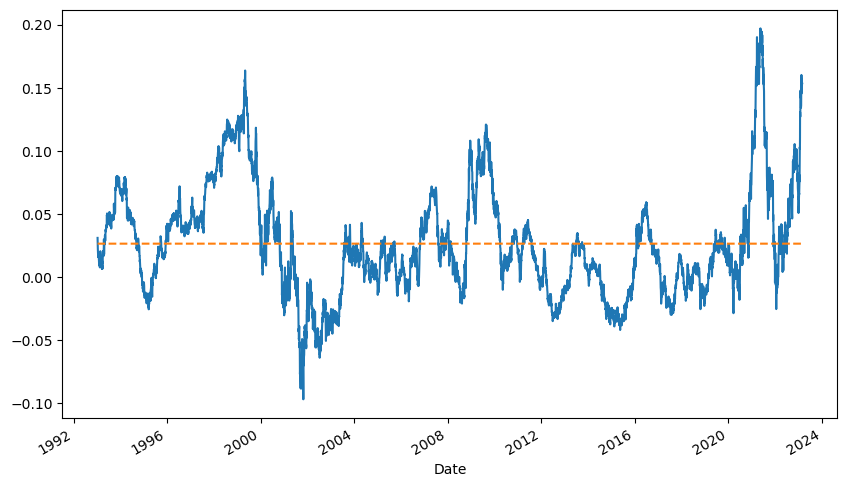

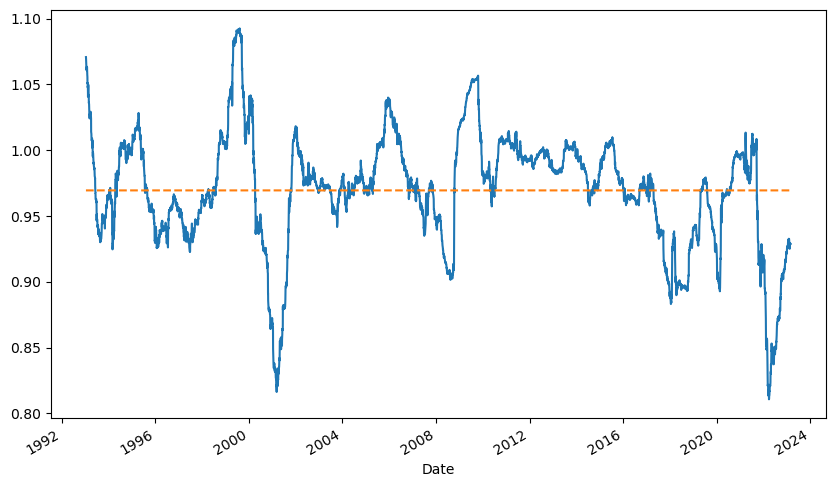

In [23]:
# we can also check the stability of alpha and market beta coefficients through time
model_roll = RollingOLS(y, sm.add_constant(X), window=260)
res_roll = model_roll.fit()

plt.figure(figsize=(10, 6))
(res_roll.params.const*260).plot()
(res_roll.params.const*0+res_roll.params.const.mean()*260).plot(linestyle='dashed')

plt.figure(figsize=(10, 6))
(res_roll.params['Mkt-RF']).plot()
(res_roll.params['Mkt-RF']*0+res_roll.params['Mkt-RF'].mean()).plot(linestyle='dashed')


In [25]:
# calendar returns
calendar_returns = pd.concat([(bt.portfolio_perf.Value.groupby(bt.portfolio_perf.index.year).last() / bt.portfolio_perf.Value.groupby(bt.portfolio_perf.index.year).last().shift(1) - 1), 
          bt_ref.portfolio_perf.Value.groupby(bt_ref.portfolio_perf.index.year).last() / bt_ref.portfolio_perf.Value.groupby(bt_ref.portfolio_perf.index.year).last().shift(1) - 1], axis=1, ignore_index=True).transpose().dropna(axis=1).rename(index={0:'Ptf', 1:'Ref'}).transpose()
calendar_returns["Excess"] = calendar_returns["Ptf"] - calendar_returns["Ref"]

In [32]:
moments = pd.DataFrame(index=["Ann. Mean","Ann. Variance","Skewness","Kurtosis"], columns=calendar_returns.columns)
moments.loc["Ann. Mean", "Ptf"] = bt.portfolio_perf.Perf.mean() * 260
moments.loc["Ann. Variance", "Ptf"] = bt.portfolio_perf.Perf.var() * 260
moments.loc["Skewness", "Ptf"] = bt.portfolio_perf.Perf.skew()
moments.loc["Kurtosis", "Ptf"] = bt.portfolio_perf.Perf.kurt()

moments.loc["Ann. Mean", "Ref"] = bt_ref.portfolio_perf.Perf.mean() * 260
moments.loc["Ann. Variance", "Ref"] = bt_ref.portfolio_perf.Perf.var() * 260
moments.loc["Skewness", "Ref"] = bt_ref.portfolio_perf.Perf.skew()
moments.loc["Kurtosis", "Ref"] = bt_ref.portfolio_perf.Perf.kurt()

moments.loc["Ann. Mean", "Excess"] = (bt.portfolio_perf.Perf - bt_ref.portfolio_perf.Perf).mean() * 260
moments.loc["Ann. Variance", "Excess"] = (bt.portfolio_perf.Perf - bt_ref.portfolio_perf.Perf).var() * 260
moments.loc["Skewness", "Excess"] = (bt.portfolio_perf.Perf - bt_ref.portfolio_perf.Perf).skew()
moments.loc["Kurtosis", "Excess"] = (bt.portfolio_perf.Perf - bt_ref.portfolio_perf.Perf).kurt()
moments

,Ptf,Ref,Excess
Ann. Mean,0.132386,0.122173,0.010213
Ann. Variance,0.031624,0.030849,0.000714
Skewness,-0.268444,-0.297996,-0.00664
Kurtosis,12.475995,11.487516,5.24279
